In [14]:
""" Module for importing PraireView5.0+ generated .csv files."""
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utilities as util
from scipy.optimize import curve_fit
from lxml import etree
from glob import glob
%matplotlib inline

In [15]:
def _get_ephys_vals(element):
    ch_type = element.find('.//PatchclampChannel').text

    if ch_type == '0':
        unit = element.find('.//UnitName').text
        divisor = float(element.find('.//Divisor').text)

        return 'primary', {'unit': unit, 'divisor': divisor}

    elif ch_type == '1':
        unit = element.find('.//UnitName').text
        divisor = float(element.find('.//Divisor').text)

        return 'secondary', {'unit': unit, 'divisor': divisor}

In [16]:
def parse_xml(filename):
    tree = etree.parse(filename)
    # find all elements associated with enabled channels
    enabled_ch = tree.xpath('.//Enabled[text()="true"]')

    file_attr = {}
    ch_names = []
    for ch in enabled_ch:
        parent = ch.getparent()
        if parent.find('.//Type').text == 'Physical':
            clamp_device = parent.find('.//PatchclampDevice').text

            if clamp_device is not None:
                name, ephys_vals = _get_ephys_vals(parent)
                file_attr[name] = ephys_vals

            else:
                name = parent.find('.//Name').text

            ch_names.append(name.capitalize())

    file_attr['channels'] = ch_names
    # gets sampling rate
    file_attr['sampling'] = int((tree.find('.//Rate')).text)
    # gets recording time, converts to sec
    file_attr['duration'] = (int((tree.find('.//AcquisitionTime')).text))#/1000

    # finds the voltage recording csv file name
    datafile = (tree.find('.//DataFile')).text
    # finds the linescan profile file name (if doesn't exist, will be None)
    ls_file = (tree.find('.//AssociatedLinescanProfileFile')).text

    # If ls_file is none this could mean that there is no linescan associated
    # with that voltage recording file or that the file passed to parse_vr is
    # actually a LineScan data file and therefore should be passed to ls_file.
    # In that scenario there is no voltage recording file, so vo_file is None
    if ls_file is None:
        if "LineScan" in datafile:
            ls_file = datafile
            vo_file = None
        elif "LineScan" not in datafile:
            vo_file = datafile
    else:
        vo_file = datafile

    file_attr['voltage recording file'] = vo_file
    file_attr['linescan file'] = ls_file

    return file_attr

In [17]:
def import_vr_csv(filename, col_names, primary_div=1, secondary_div=1):
    """
    Reads voltage recording .csv file into a pandas dataframe.
    Will convert Primary and Secondary channels to appropriate values if those
    channels are in the file.
    Returns a dataframe
    """

    df = pd.read_csv(filename, names=col_names, skiprows=1)
    #df.Time /= 1000

    if "Primary" in df.columns:
        df.Primary /= primary_div
    if "Secondary" in df.columns:
        df.Secondary /= secondary_div

    return df



In [18]:
def import_folder(folder):
    """Collapse entire data folder into multidimensional dataframe
    Returns a dictionary with "voltage recording", "linescan" and
    "file attributes" keys associate with 2 dataframes and a dictionary
    (respective).
    """
    vr_xmls = glob(os.path.join(folder, '*_VoltageRecording_*.xml'))

    if any(vr_xmls):
        data_vr = []
        data_ls = []
        sweep_list = []
        file_attr = {}
        output = {}

        for i, file in enumerate(vr_xmls):
            sweep = 'Sweep' + str(i+1).zfill(4)
            sweep_list.append(sweep)
            file_vals = parse_xml(file)

            if file_vals['voltage recording file'] is not None:
                vr_filename = os.path.join(folder,
                                           (file_vals['voltage recording file']
                                            + '.csv'))
                col_names = ['Time'] + file_vals['channels']
                primary_divisor = file_vals['primary']['divisor']
                #secondary_divisor = file_vals['secondary']['divisor']

                df_vr = import_vr_csv(vr_filename, col_names, primary_divisor,1)

                data_vr.append(df_vr)

            if file_vals['linescan file'] is not None:
                ls_filename = os.path.join(folder,
                                           (file_vals['linescan file']))

                df_ls = import_ls_csv(ls_filename)

                data_ls.append(df_ls)

            file_attr['File'+str(i+1)] = file_vals

        if data_vr:
            output["voltage recording"] = pd.concat(data_vr, keys=sweep_list,
                                                    names=['Sweep', 'Index'])
        elif not data_vr:
            output["voltage recording"] = None
        if data_ls:
            output["linescan"] = pd.concat(data_ls, keys=sweep_list,
                                           names=['Sweep', 'Index'])
        elif not data_ls:
            output["linescan"] = None
        output["file attributes"] = file_attr

    else:
        output = {"voltage recording": None, "linescan": None,
                  "file attributes": None}

    return output

In [19]:
vr_folders = glob(os.path.join('/Users/shenyuzhai/Desktop/in_progress/', 'cell*-***'))
vr_folders = sorted(vr_folders)
df_vr_list = []
trace_list = []
for i, folder in enumerate(vr_folders):
        #col_names = ['Time'] + ['Primary']
        df_vr = import_folder(vr_folders[i])['voltage recording']
        df_vr_list.append(df_vr)
        trace = 'celli-' + str(i+1).zfill(3)
        trace_list.append(trace)
        #aligneddata = pd.concat(df_vr_list, keys=trace_list)

(-100, -80)

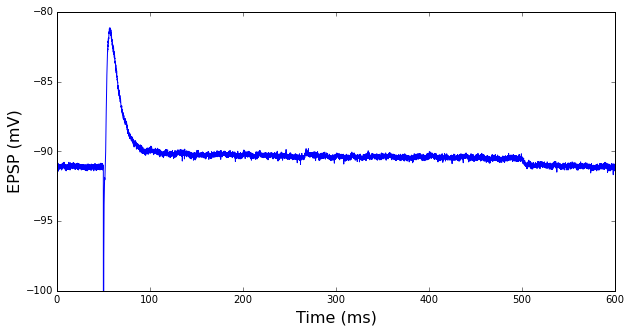

In [28]:
#Plot one trace to see
plt.figure(figsize=(10,5))
plt.plot(df_vr_list[5].Time, df_vr_list[106].Primary)
plt.ylabel('EPSP (mV)', fontsize=16)
plt.xlabel('Time (ms)', fontsize=16)
plt.xlim(0,600)
plt.ylim(-100,-80)

In [21]:
def analyze_EPSC(df, bsl_start, bsl_end, start_time, end_time, pulse_start):
    """
    df: data as pandas dataframe
        should contain Time and Primary columns
    bsl_start: designates beginning of the time window for baseline measurement
    bsl_end: designates end of the time window for baseline measurement
    start_time: positive number (time, ms)
        designates beginning of time window for EPSC measurement
    end_time: positive number (time, ms)
        designates end of time window for EPSC measurement
    pulse_start: designates the start of -5mV pulse for parameter measurements
    """
    # have to make copy of df to not modify original df with calculation
    data = df.copy()
    I_holding = data.Primary[(data.Time >= bsl_start) &
                              (data.Time <= bsl_end)].mean()
    EPSC_df= (data.Primary[(data.Time>=start_time) & (data.Time <=end_time)].max())-I_holding
   
    '''conversions - pulse_amp is in mVs, data.Primary is in pAs'''
    #calculate pre-pulse Vm
    I_pre = data.Primary[(data.Time >= (pulse_start-101)) &
                             (data.Time <= (pulse_start-1))].mean()
    #calculate steady state Vm
    I_ss = data.Primary[(data.Time >= (pulse_start+400)) &
                              (data.Time <= (pulse_start+500))].mean()
    # calculate delta_i -- i.e. difference between baseline current amplitude and steady-state current amplitude
    delta_i = (I_ss-I_pre)
    cap_df = util.find_peak(data, pulse_start, pulse_start+20, 'min')
    #cap_peak = cap_df['Peak Amp'].values[0]-I_holding
    # resistance calculations
    #ra = -5000/cap_peak
    Rin = delta_i/-0.02
    result_list = [EPSC_df, I_holding, Rin]
    return result_list

In [22]:
analyze_EPSC(df_vr_list[30], 1, 49, 52, 200, 500)

[3.4125123846803547, -89.502600275305355, 33.903169584322512]

In [23]:
len(df_vr_list)

137

In [24]:
result_list = []
for i in range(len(df_vr_list)):
    result = analyze_EPSC(df_vr_list[i], 1, 49, 52, 100, 500)
    result_list.append(result)
#result_list

In [25]:
bsl=8
start_treatment_after=40
timepoint_list = []
for i in range(len(df_vr_list)):
    timepoint = (i/3)-((start_treatment_after/3)-bsl)
    timepoint_list.append(timepoint)
    
df1=pd.DataFrame(result_list,  columns = ['EPSP', 'Ih', 'Rin'])
df1['Time'] = pd.Series(timepoint_list)
df1 = df1[['Time', 'EPSP', 'Rin', 'Ih']]

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


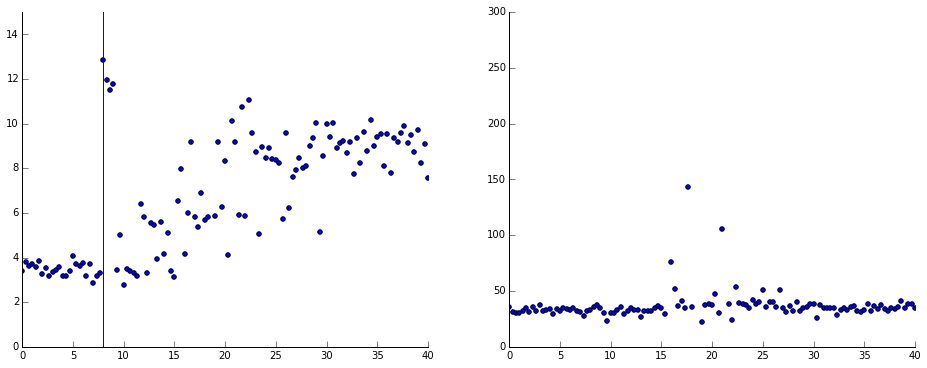

In [26]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize = (16,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)

ax1 = plt.subplot(gs[0])
ax1.scatter(df1['Time'], df1['EPSP'])
#ax1.plt((10, 0), (10, 10), color="#aaaaaa")
ax1.set_xlim(0,40)
ax1.set_ylim(0,15)
ax1.plot([bsl,bsl], (0,200))
# hide top and right axes
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.tick_params(which='both', top='off', right='off')

ax1.get_yaxis().set_tick_params(which="both", direction="in", length=6)
ax1.get_xaxis().set_tick_params(which="both", direction="in", length=6)

ax2 = plt.subplot(gs[1])
ax2.scatter(df1['Time'], df1['Rin'])
ax2.set_xlim(0,40)
ax2.set_ylim(0,300)

# hide top and right axes
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.tick_params(which='both', top='off', right='off')

#ax2.set_yticks([5, 10, 15, 20])
#ax2.set_yticks([x*5 for x in range(1, 4)], 
#              minor=True)
ax2.get_yaxis().set_tick_params(which="both", direction="in", length=6)
ax2.get_xaxis().set_tick_params(which="both", direction="in", length=6)
#plt.show()
plt.savefig('LTD.pdf')
df1.to_csv('result.csv', index=True, header=True)